# Set up

Import needed packages, define plot settings, precalculate certain variables

In [4]:
import os
file_path = "C:/Users/hgp/Documents/bezerkeley/research/isol-sys-database/src/paper/"
dir_path = os.path.dirname(file_path)
os.chdir(dir_path)

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from doe import GP

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=20
axis_font = 18
subt_font = 18
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
pd.options.mode.chained_assignment = None  

plt.close('all')


## Load in data and carry out some pre-processing

In [13]:

main_obj = pd.read_pickle("../../data/loss/structural_db_drift_allow_loss.pickle")
    
main_obj.calculate_collapse()

df_raw = main_obj.ops_analysis
df_raw = df_raw.reset_index(drop=True)

# remove the singular outlier point
from scipy import stats
df = df_raw[np.abs(stats.zscore(df_raw['collapse_prob'])) < 5].copy()

# df = df.drop(columns=['index'])
# df = df_whole.head(100).copy()

df['max_isol_disp'] = pd.to_numeric(df['max_isol_disp'])
df['max_drift'] = df.PID.apply(max)
df['log_drift'] = np.log(df['max_drift'])

df['max_velo'] = df.PFV.apply(max)
df['max_accel'] = df.PFA.apply(max)

# df['T_ratio'] = df['T_m'] / df['T_fb']
df['T_ratio_e'] = df['T_m'] / df['T_fbe']
pi = 3.14159
g = 386.4

zetaRef = [0.02, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
BmRef   = [0.8, 1.0, 1.2, 1.5, 1.7, 1.9, 2.0]
df['Bm'] = np.interp(df['zeta_e'], zetaRef, BmRef)

df['bldg_area'] = (df['num_bays']*df['L_bay'])**2 * (df['num_stories'] + 1)

df_loss = main_obj.loss_data

max_obj = pd.read_pickle("../../data/loss/structural_db_drift_allow_max_loss.pickle")
df_loss_max = max_obj.max_loss

def wL_calc(num_stories, bldg_area):
    
    # in kip/ft^2
    LL_avg = (num_stories*50.0/1000 + 20.0/1000)/(num_stories + 1)
    W_L = LL_avg*bldg_area
    return W_L

def TFP_period_shift(W_D, W_L, bearing):
    # shift assumes that the load case is 1.0D + 0.5L
    if bearing == 'TFP':
        return (W_D/(W_D+0.5*W_L))**0.5
    else:
        return 1.0

df['W_L'] = df.apply(lambda x: wL_calc(x['num_stories'], x['bldg_area']), axis=1)
df['Tshift_coef'] = df.apply(
    lambda x: TFP_period_shift(x['W'], x['W_L'], x['isolator_system']), axis=1)

df['T_M_adj'] = pd.to_numeric(df['T_m'] * df['Tshift_coef'])

df['T_ratio'] = pd.to_numeric(df['T_M_adj']/df['T_fb'])

from gms import get_ST


df['sa_tm_adj'] = df.apply(
    lambda x: get_ST(x, x['T_M_adj'],
                      db_dir='../../resource/ground_motions/gm_db.csv',
                      spec_dir='../../resource/ground_motions/gm_spectra.csv'), 
    axis=1)
    
df['gap_ratio'] = pd.to_numeric((df['constructed_moat']*4*pi**2)/ \
    (g*(df['sa_tm_adj']/df['Bm'])*df['T_M_adj']**2))
    


## Calculate loss outcomes

In [ ]:
def moment_frame_cost(df, steel_per_unit=1.25):
    n_bays = df.num_bays
    
    # ft
    L_beam = df.L_bay
    h_story = df.h_story
    
    all_beams = df.beam
    all_cols = df.column
    
    # sum of per-length-weight of all floors
    col_wt = [float(member.split('X',1)[1]) for member in all_cols]
    beam_wt = [float(member.split('X',1)[1]) for member in all_beams] 
    
    # col_all_wt = np.array(list(map(sum, col_wt)))
    # beam_all_wt = np.array(list(map(sum, beam_wt)))
    
    # only 2 lateral frames
    n_frames = 4
    n_cols = 4*n_bays
    
    floor_col_length = np.array(n_cols*h_story, dtype=float)
    floor_beam_length = np.array(L_beam * n_bays * n_frames, dtype=float)
        
    floor_col_wt = col_wt*floor_col_length 
    floor_beam_wt = beam_wt*floor_beam_length
    
    bldg_wt = sum(floor_col_wt) + sum(floor_beam_wt)
    
    steel_cost = steel_per_unit*bldg_wt
    return(steel_cost)

def braced_frame_cost(df, brace_db, steel_per_unit=1.25):
    n_bays = df.num_bays
    
    # ft
    L_beam = df.L_bay
    h_story = df.h_story
    n_stories = df.num_stories
    
    from math import atan, cos
    theta = atan(h_story/(L_beam/2))
    L_brace = (L_beam/2)/cos(theta)
    
    all_beams = df.beam
    all_cols = df.column
    all_braces = df.brace
    
    n_braced = int(round(n_bays/2.25))
    n_braced = max(n_braced, 1)
    
    # sum of per-length-weight of all floors
    col_wt = [float(member.split('X',1)[1]) for member in all_cols]
    beam_wt = [float(member.split('X',1)[1]) for member in all_beams] 
    brace_wt = [brace_db.loc[brace_db['AISC_Manual_Label'] == brace_name]['W'].item() 
                    for brace_name in all_braces]
    
    # only 2 lateral frames
    n_frames = 4
    
    # in CBF, only count the big frames
    n_cols = 4*(n_braced+1)
    
    floor_col_length = np.array(n_cols*h_story, dtype=float)
    floor_beam_length = np.array(L_beam * n_braced * n_frames, dtype=float)
    floor_brace_length = np.array(L_brace * n_braced * n_frames, dtype=float)
    
    n_every_col = 4*n_bays
    full_frame_col_length = np.array(n_every_col*h_story, dtype=float)
    full_frame_beam_length = np.array(L_beam * n_bays * n_frames, dtype=float)
    grav_col_length = full_frame_col_length - floor_col_length
    grav_beam_length = full_frame_beam_length - floor_beam_length
    
    # assume W14x120 grav columns, W16x31 beams
    grav_col_wt = np.repeat(120.0, n_stories)*grav_col_length
    grav_beam_wt = np.repeat(31.0, n_stories)*grav_beam_length
    
    floor_col_wt = col_wt*floor_col_length 
    floor_beam_wt = beam_wt*floor_beam_length
    floor_brace_wt = brace_wt*floor_brace_length
    
    bldg_wt = (sum(floor_col_wt) + sum(floor_beam_wt) + sum(floor_brace_wt) +
               sum(grav_col_wt) + sum(grav_beam_wt))
    
    steel_cost = steel_per_unit*bldg_wt
    
    return(steel_cost)

# calc cost of existing db
def calc_steel_cost(df, brace_db, steel_per_unit=1.25):
    superstructure_system = df.superstructure_system
    
    if superstructure_system == 'MF':
        return moment_frame_cost(df, steel_per_unit=steel_per_unit)
    else:
        return braced_frame_cost(df, brace_db, steel_per_unit=steel_per_unit)
    
#%% normalize DVs and prepare all variables

def loss_percentages(df_main, df_loss, df_max):
    df_main['bldg_area'] = df_main['L_bldg']**2 * (df_main['num_stories'] + 1)

    df_main['replacement_cost'] = 600.0*(df_main['bldg_area'])
    df_main['total_cmp_cost'] = df_max['cost_50%']
    df_main['total_cmp_cost_ub'] = df_max['cost_90%']
    df_main['cmp_replace_cost_ratio'] = df_main['total_cmp_cost']/df_main['replacement_cost']
    df_main['median_cost_ratio'] = df_loss['cost_50%']/df_main['replacement_cost']
    df_main['cmp_cost_ratio'] = df_loss['cost_50%']/df_main['total_cmp_cost']

    # but working in parallel (2x faster)
    df_main['replacement_time'] = df_main['bldg_area']/1000*365
    df_main['total_cmp_time'] = df_max['time_l_50%']
    df_main['total_cmp_time_ub'] = df_max['time_l_90%']
    df_main['cmp_replace_time_ratio'] = df_main['total_cmp_time']/df_main['replacement_time']
    df_main['median_time_ratio'] = df_loss['time_l_50%']/df_main['replacement_time']
    df_main['cmp_time_ratio'] = df_loss['time_l_50%']/df_main['total_cmp_time']

    df_main['replacement_freq'] = df_loss['replacement_freq']

    df_main[['B_50%', 'C_50%', 'D_50%', 'E_50%']] = df_loss[['B_50%', 'C_50%', 'D_50%', 'E_50%']]

    df_main['impacted'] = pd.to_numeric(df_main['impacted'])

    mask = df_loss['B_50%'].isnull()

    df_main['B_50%'].loc[mask] = df_max['B_50%'].loc[mask]
    df_main['C_50%'].loc[mask] = df_max['C_50%'].loc[mask]
    df_main['D_50%'].loc[mask] = df_max['D_50%'].loc[mask]
    df_main['E_50%'].loc[mask] = df_max['E_50%'].loc[mask]
    
    copied_vars = ['cost_theta', 'cost_beta', 'time_l_theta', 'time_l_beta',
                   'cost_lam', 'cost_k', 'time_l_k', 'time_l_lam',
                   'cost_weibull_ks_pvalue', 'cost_lognormal_ks_pvalue',
                   'time_l_weibull_ks_pvalue', 'time_l_lognormal_ks_pvalue',
                   'cost_weibull_aic', 'cost_lognormal_aic',
                   'time_l_weibull_aic', 'time_l_lognormal_aic']
    
    df_main[copied_vars] = df_loss[copied_vars]
    return(df_main)
    
df = loss_percentages(df, df_loss, df_loss_max)

db_string = '../../resource/'
brace_db = pd.read_csv(db_string+'braceShapes.csv', index_col=None, header=0)  

df['steel_cost'] = df.apply(
       lambda row: calc_steel_cost(
           row, brace_db=brace_db,
           steel_per_unit=1.25),
       axis='columns', result_type='expand')

df['steel_cost_per_sf'] = df['steel_cost'] / df['bldg_area']

df['system'] = df['superstructure_system'] +'-' + df['isolator_system']

print(df.columns)
df.head()

Index(['superstructure_system', 'isolator_system', 'num_frames', 'S_1', 'T_m',
       'k_ratio', 'moat_ampli', 'RI', 'L_bldg', 'h_bldg',
       ...
       'cost_lognormal_ks_pvalue', 'time_l_weibull_ks_pvalue',
       'time_l_lognormal_ks_pvalue', 'cost_weibull_aic', 'cost_lognormal_aic',
       'time_l_weibull_aic', 'time_l_lognormal_aic', 'steel_cost',
       'steel_cost_per_sf', 'system'],
      dtype='object', length=122)


,superstructure_system,isolator_system,num_frames,S_1,T_m,k_ratio,moat_ampli,RI,L_bldg,h_bldg,...,cost_lognormal_ks_pvalue,time_l_weibull_ks_pvalue,time_l_lognormal_ks_pvalue,cost_weibull_aic,cost_lognormal_aic,time_l_weibull_aic,time_l_lognormal_aic,steel_cost,steel_cost_per_sf,system
0,CBF,TFP,2.0,1.248156,3.543509,14.649668,0.559622,1.602873,84.330713,33.879726,...,3.175526e-01,7.357589e-01,3.175526e-01,25537.572643,-32609.695932,9021.411950,-49148.154207,97594.701159,4.574393,CBF-TFP
1,CBF,LRB,2.0,1.1376,3.052741,17.368904,0.904996,1.950874,141.727436,68.750287,...,1.173900e-12,1.038574e-41,3.590891e-11,29305.489929,28363.036885,14199.566659,13567.316511,512953.307551,4.256168,CBF-LRB
2,CBF,TFP,2.0,1.231249,3.021773,9.721468,0.853225,1.837052,227.902243,36.439439,...,4.034366e-31,1.164289e-56,1.960622e-24,33261.427058,32333.547151,18298.673164,17606.498910,463783.126373,2.232327,CBF-TFP
3,CBF,TFP,2.0,1.177128,4.934639,10.552295,1.197248,1.870806,189.289449,30.418861,...,1.512282e-01,4.266528e-04,2.470871e-01,27226.736497,27131.954495,13094.250168,13004.386534,239623.985045,2.229237,CBF-TFP
4,CBF,TFP,2.0,1.149968,4.377883,11.332631,0.972307,1.405487,103.165654,68.123138,...,3.725281e-16,1.728823e-57,4.411734e-11,29395.558777,28304.252359,14131.477995,13282.406515,361937.157451,5.667763,CBF-TFP


## Subset of data

In [7]:
df_tfp = df[df['isolator_system'] == 'TFP']
df_lrb = df[df['isolator_system'] == 'LRB']

df_cbf = df[df['superstructure_system'] == 'CBF'].reset_index()
df_cbf['dummy_index'] = df_cbf['replacement_freq'] + df_cbf['index']*1e-9
df_mf = df[df['superstructure_system'] == 'MF'].reset_index()
df_mf['dummy_index'] = df_mf['replacement_freq'] + df_mf['index']*1e-9

df_mf_o = df_mf[df_mf['impacted'] == 0]
df_cbf_o = df_cbf[df_cbf['impacted'] == 0]

df_mf_tfp = df_tfp[df_tfp['superstructure_system'] == 'MF']
df_mf_lrb = df_lrb[df_lrb['superstructure_system'] == 'MF']

df_cbf_tfp = df_tfp[df_tfp['superstructure_system'] == 'CBF']
df_cbf_lrb = df_lrb[df_lrb['superstructure_system'] == 'CBF']


df_mf_tfp_i = df_mf_tfp[df_mf_tfp['impacted'] == 1]
df_mf_tfp_o = df_mf_tfp[df_mf_tfp['impacted'] == 0]
df_mf_lrb_i = df_mf_lrb[df_mf_lrb['impacted'] == 1]
df_mf_lrb_o = df_mf_lrb[df_mf_lrb['impacted'] == 0]

df_cbf_tfp_i = df_cbf_tfp[df_cbf_tfp['impacted'] == 1]
df_cbf_tfp_o = df_cbf_tfp[df_cbf_tfp['impacted'] == 0]
df_cbf_lrb_i = df_cbf_lrb[df_cbf_lrb['impacted'] == 1]
df_cbf_lrb_o = df_cbf_lrb[df_cbf_lrb['impacted'] == 0]

## Visualize data

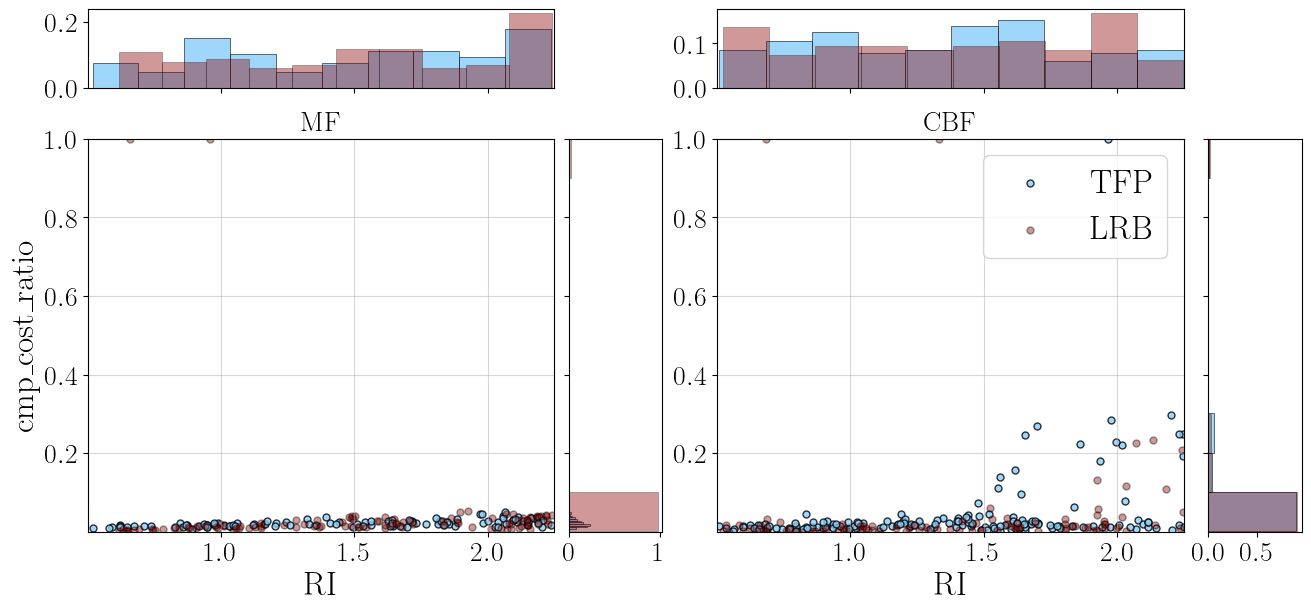

In [ ]:
#%%

def scatter_hist(x, y, c, alpha, ax, ax_histx, ax_histy, label=None):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # ax_histx.grid(True)
    # ax_histy.grid(True)
    
    # the scatter plot:
    ax.grid(True, alpha=0.5)
    ax.scatter(x, y, alpha=alpha, edgecolors='black', s=25, facecolors=c,
                label=label)

    n_bins = 10
    ax_histx.hist(x, bins=n_bins, alpha = alpha, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='black', linewidth=0.5)
    
    ax_histy.hist(y, bins=n_bins, orientation='horizontal', alpha = alpha, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='black', linewidth=0.5)
  

xvar = 'RI'
yvar = 'cmp_cost_ratio'

df_a1 = df_mf[df_mf['S_1'] > 1.1]
df_a2 = df_cbf[df_cbf['S_1'] > 1.1]

# TODO: simpler scatter
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 24
subt_font = 22
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

plt.close('all')
# Start with a square Figure.
fig = plt.figure(figsize=(13, 6), layout='constrained')

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(5, 1, 5, 1), height_ratios=(1, 5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0., hspace=0.)
# # Create the Axes.
# fig = plt.figure(figsize=(13, 10))
# ax1=fig.add_subplot(2, 2, 1)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Draw the scatter plot and marginals.
scatter_hist(df_mf_tfp_o[xvar], df_mf_tfp_o[yvar], 'lightskyblue', 0.8, ax, ax_histx, ax_histy,
             label='TFP')
scatter_hist(df_mf_lrb_o[xvar], df_mf_lrb_o[yvar], 'darkred', 0.4, ax, ax_histx, ax_histy,
             label='LRB')
# ax.legend(fontsize=axis_font)

ax.set_title(r'MF', fontsize=title_font)

ax.set_xlabel(xvar, fontsize=axis_font)
ax.set_ylabel(yvar, fontsize=axis_font)
ax.set_xlim([df[xvar].min(), df[xvar].max()])
ax.set_ylim([df[yvar].min(), df[yvar].max()])

ax = fig.add_subplot(gs[1, 2])
ax_histx = fig.add_subplot(gs[0, 2], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 3], sharey=ax)

# Draw the scatter plot and marginals.

scatter_hist(df_cbf_tfp_o[xvar], df_cbf_tfp_o[yvar], 'lightskyblue', 0.8, ax, ax_histx, ax_histy,
              label='TFP')
scatter_hist(df_cbf_lrb_o[xvar], df_cbf_lrb_o[yvar], 'darkred', 0.4, ax, ax_histx, ax_histy,
              label='LRB')

ax.set_xlim([df[xvar].min(), df[xvar].max()])
ax.set_ylim([df[yvar].min(), df[yvar].max()])

ax.set_title(r'CBF', fontsize=title_font)
ax.set_xlabel(xvar, fontsize=axis_font)

ax.legend(fontsize=axis_font)

# Gaussian process models

In [ ]:
cost_var = 'cmp_cost_ratio'
time_var = 'cmp_time_ratio'
repl_var= 'replacement_freq'
covariate_list = ['gap_ratio', 'RI', 'T_ratio', 'zeta_e']   

Impact classification models

In [14]:
#%% impact classification model
# for each system, make separate impact classification model

mdl_all = GP(df)
mdl_all.set_covariates(covariate_list)

mdl_impact_cbf_lrb = GP(df_cbf_lrb)
mdl_impact_cbf_lrb.set_covariates(covariate_list)
mdl_impact_cbf_lrb.set_outcome('impacted')
mdl_impact_cbf_lrb.test_train_split(0.2)

mdl_impact_cbf_tfp = GP(df_cbf_tfp)
mdl_impact_cbf_tfp.set_covariates(covariate_list)
mdl_impact_cbf_tfp.set_outcome('impacted')
mdl_impact_cbf_tfp.test_train_split(0.2)

mdl_impact_mf_lrb = GP(df_mf_lrb)
mdl_impact_mf_lrb.set_covariates(covariate_list)
mdl_impact_mf_lrb.set_outcome('impacted')
mdl_impact_mf_lrb.test_train_split(0.2)

mdl_impact_mf_tfp = GP(df_mf_tfp)
mdl_impact_mf_tfp.set_covariates(covariate_list)
mdl_impact_mf_tfp.set_outcome('impacted')
mdl_impact_mf_tfp.test_train_split(0.2)

print('======= impact classification per system ========')
import time
t0 = time.time()

mdl_impact_cbf_lrb.fit_gpc(kernel_name='rbf_iso')
mdl_impact_cbf_tfp.fit_gpc(kernel_name='rbf_iso')
mdl_impact_mf_lrb.fit_gpc(kernel_name='rbf_iso')
mdl_impact_mf_tfp.fit_gpc(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPC training for impact done for 4 models in %.3f s" % tp)

# density estimation model to enable constructability 
print('======= Density estimation per system ========')

t0 = time.time()

mdl_impact_mf_lrb.fit_kde()
mdl_impact_cbf_lrb.fit_kde()
mdl_impact_mf_tfp.fit_kde()
mdl_impact_cbf_tfp.fit_kde()

tp = time.time() - t0

print("KDE training done for 4 models in %.3f s" % tp)


impact_classification_mdls = {'mdl_impact_cbf_lrb': mdl_impact_cbf_lrb,
                        'mdl_impact_cbf_tfp': mdl_impact_cbf_tfp,
                        'mdl_impact_mf_lrb': mdl_impact_mf_lrb,
                        'mdl_impact_mf_tfp': mdl_impact_mf_tfp}

======= impact classification per system ========
The GP training score is 0.760
The GP testing score is 0.750
The GP training score is 0.758
The GP testing score is 0.733
The GP training score is 0.797
The GP testing score is 0.864
The GP training score is 0.760
The GP testing score is 0.643
GPC training for impact done for 4 models in 1.081 s
======= Density estimation per system ========
KDE training done for 4 models in 3.855 s


Cost regression models

In [ ]:
mdl_cost_cbf_lrb_i = GP(df_cbf_lrb_i)
mdl_cost_cbf_lrb_i.set_covariates(covariate_list)
mdl_cost_cbf_lrb_i.set_outcome(cost_var)
mdl_cost_cbf_lrb_i.test_train_split(0.2)

mdl_cost_cbf_lrb_o = GP(df_cbf_lrb_o)
mdl_cost_cbf_lrb_o.set_covariates(covariate_list)
mdl_cost_cbf_lrb_o.set_outcome(cost_var)
mdl_cost_cbf_lrb_o.test_train_split(0.2)

mdl_cost_cbf_tfp_i = GP(df_cbf_tfp_i)
mdl_cost_cbf_tfp_i.set_covariates(covariate_list)
mdl_cost_cbf_tfp_i.set_outcome(cost_var)
mdl_cost_cbf_tfp_i.test_train_split(0.2)

mdl_cost_cbf_tfp_o = GP(df_cbf_tfp_o)
mdl_cost_cbf_tfp_o.set_covariates(covariate_list)
mdl_cost_cbf_tfp_o.set_outcome(cost_var)
mdl_cost_cbf_tfp_o.test_train_split(0.2)

mdl_cost_mf_lrb_i = GP(df_mf_lrb_i)
mdl_cost_mf_lrb_i.set_covariates(covariate_list)
mdl_cost_mf_lrb_i.set_outcome(cost_var)
mdl_cost_mf_lrb_i.test_train_split(0.2)

mdl_cost_mf_lrb_o = GP(df_mf_lrb_o)
mdl_cost_mf_lrb_o.set_covariates(covariate_list)
mdl_cost_mf_lrb_o.set_outcome(cost_var)
mdl_cost_mf_lrb_o.test_train_split(0.2)

mdl_cost_mf_tfp_i = GP(df_mf_tfp_i)
mdl_cost_mf_tfp_i.set_covariates(covariate_list)
mdl_cost_mf_tfp_i.set_outcome(cost_var)
mdl_cost_mf_tfp_i.test_train_split(0.2)

mdl_cost_mf_tfp_o = GP(df_mf_tfp_o)
mdl_cost_mf_tfp_o.set_covariates(covariate_list)
mdl_cost_mf_tfp_o.set_outcome(cost_var)
mdl_cost_mf_tfp_o.test_train_split(0.2)

print('======= cost regression per system per impact ========')
import time
t0 = time.time()

mdl_cost_cbf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_tfp_o.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_tfp_o.fit_gpr(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPR training for cost done for 8 models in %.3f s" % tp)

cost_regression_mdls = {'mdl_cost_cbf_lrb_i': mdl_cost_cbf_lrb_i,
                        'mdl_cost_cbf_lrb_o': mdl_cost_cbf_lrb_o,
                        'mdl_cost_cbf_tfp_i': mdl_cost_cbf_tfp_i,
                        'mdl_cost_cbf_tfp_o': mdl_cost_cbf_tfp_o,
                        'mdl_cost_mf_lrb_i': mdl_cost_mf_lrb_i,
                        'mdl_cost_mf_lrb_o': mdl_cost_mf_lrb_o,
                        'mdl_cost_mf_tfp_i': mdl_cost_mf_tfp_i,
                        'mdl_cost_mf_tfp_o': mdl_cost_mf_tfp_o}

Downtime regression models

In [ ]:
#%% regression models: time
# goal: E[time|sys=sys, impact=impact]

mdl_time_cbf_lrb_i = GP(df_cbf_lrb_i)
mdl_time_cbf_lrb_i.set_covariates(covariate_list)
mdl_time_cbf_lrb_i.set_outcome(time_var)
mdl_time_cbf_lrb_i.test_train_split(0.2)

mdl_time_cbf_lrb_o = GP(df_cbf_lrb_o)
mdl_time_cbf_lrb_o.set_covariates(covariate_list)
mdl_time_cbf_lrb_o.set_outcome(time_var)
mdl_time_cbf_lrb_o.test_train_split(0.2)

mdl_time_cbf_tfp_i = GP(df_cbf_tfp_i)
mdl_time_cbf_tfp_i.set_covariates(covariate_list)
mdl_time_cbf_tfp_i.set_outcome(time_var)
mdl_time_cbf_tfp_i.test_train_split(0.2)

mdl_time_cbf_tfp_o = GP(df_cbf_tfp_o)
mdl_time_cbf_tfp_o.set_covariates(covariate_list)
mdl_time_cbf_tfp_o.set_outcome(time_var)
mdl_time_cbf_tfp_o.test_train_split(0.2)

mdl_time_mf_lrb_i = GP(df_mf_lrb_i)
mdl_time_mf_lrb_i.set_covariates(covariate_list)
mdl_time_mf_lrb_i.set_outcome(time_var)
mdl_time_mf_lrb_i.test_train_split(0.2)

mdl_time_mf_lrb_o = GP(df_mf_lrb_o)
mdl_time_mf_lrb_o.set_covariates(covariate_list)
mdl_time_mf_lrb_o.set_outcome(time_var)
mdl_time_mf_lrb_o.test_train_split(0.2)

mdl_time_mf_tfp_i = GP(df_mf_tfp_i)
mdl_time_mf_tfp_i.set_covariates(covariate_list)
mdl_time_mf_tfp_i.set_outcome(time_var)
mdl_time_mf_tfp_i.test_train_split(0.2)

mdl_time_mf_tfp_o = GP(df_mf_tfp_o)
mdl_time_mf_tfp_o.set_covariates(covariate_list)
mdl_time_mf_tfp_o.set_outcome(time_var)
mdl_time_mf_tfp_o.test_train_split(0.2)

print('======= downtime regression per system per impact ========')
import time
t0 = time.time()

mdl_time_cbf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_tfp_o.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_tfp_o.fit_gpr(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPR training for time done for 8 models in %.3f s" % tp)

time_regression_mdls = {'mdl_time_cbf_lrb_i': mdl_time_cbf_lrb_i,
                        'mdl_time_cbf_lrb_o': mdl_time_cbf_lrb_o,
                        'mdl_time_cbf_tfp_i': mdl_time_cbf_tfp_i,
                        'mdl_time_cbf_tfp_o': mdl_time_cbf_tfp_o,
                        'mdl_time_mf_lrb_i': mdl_time_mf_lrb_i,
                        'mdl_time_mf_lrb_o': mdl_time_mf_lrb_o,
                        'mdl_time_mf_tfp_i': mdl_time_mf_tfp_i,
                        'mdl_time_mf_tfp_o': mdl_time_mf_tfp_o}

Replacement probability regression model

In [ ]:
#%% regression models: repl
# goal: E[repl|sys=sys, impact=impact]

mdl_repl_cbf_lrb_i = GP(df_cbf_lrb_i)
mdl_repl_cbf_lrb_i.set_covariates(covariate_list)
mdl_repl_cbf_lrb_i.set_outcome('replacement_freq')
mdl_repl_cbf_lrb_i.test_train_split(0.2)

mdl_repl_cbf_lrb_o = GP(df_cbf_lrb_o)
mdl_repl_cbf_lrb_o.set_covariates(covariate_list)
mdl_repl_cbf_lrb_o.set_outcome('replacement_freq')
mdl_repl_cbf_lrb_o.test_train_split(0.2)

mdl_repl_cbf_tfp_i = GP(df_cbf_tfp_i)
mdl_repl_cbf_tfp_i.set_covariates(covariate_list)
mdl_repl_cbf_tfp_i.set_outcome('replacement_freq')
mdl_repl_cbf_tfp_i.test_train_split(0.2)

mdl_repl_cbf_tfp_o = GP(df_cbf_tfp_o)
mdl_repl_cbf_tfp_o.set_covariates(covariate_list)
mdl_repl_cbf_tfp_o.set_outcome('replacement_freq')
mdl_repl_cbf_tfp_o.test_train_split(0.2)

mdl_repl_mf_lrb_i = GP(df_mf_lrb_i)
mdl_repl_mf_lrb_i.set_covariates(covariate_list)
mdl_repl_mf_lrb_i.set_outcome('replacement_freq')
mdl_repl_mf_lrb_i.test_train_split(0.2)

mdl_repl_mf_lrb_o = GP(df_mf_lrb_o)
mdl_repl_mf_lrb_o.set_covariates(covariate_list)
mdl_repl_mf_lrb_o.set_outcome('replacement_freq')
mdl_repl_mf_lrb_o.test_train_split(0.2)

mdl_repl_mf_tfp_i = GP(df_mf_tfp_i)
mdl_repl_mf_tfp_i.set_covariates(covariate_list)
mdl_repl_mf_tfp_i.set_outcome('replacement_freq')
mdl_repl_mf_tfp_i.test_train_split(0.2)

mdl_repl_mf_tfp_o = GP(df_mf_tfp_o)
mdl_repl_mf_tfp_o.set_covariates(covariate_list)
mdl_repl_mf_tfp_o.set_outcome('replacement_freq')
mdl_repl_mf_tfp_o.test_train_split(0.2)

t0 = time.time()

print('======= replacement regression per system per impact ========')

mdl_repl_cbf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_repl_cbf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_repl_cbf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_repl_cbf_tfp_o.fit_gpr(kernel_name='rbf_iso')
mdl_repl_mf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_repl_mf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_repl_mf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_repl_mf_tfp_o.fit_gpr(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPR training for replacement done for 8 models in %.3f s" % tp)

repl_regression_mdls = {'mdl_repl_cbf_lrb_i': mdl_repl_cbf_lrb_i,
                        'mdl_repl_cbf_lrb_o': mdl_repl_cbf_lrb_o,
                        'mdl_repl_cbf_tfp_i': mdl_repl_cbf_tfp_i,
                        'mdl_repl_cbf_tfp_o': mdl_repl_cbf_tfp_o,
                        'mdl_repl_mf_lrb_i': mdl_repl_mf_lrb_i,
                        'mdl_repl_mf_lrb_o': mdl_repl_mf_lrb_o,
                        'mdl_repl_mf_tfp_i': mdl_repl_mf_tfp_i,
                        'mdl_repl_mf_tfp_o': mdl_repl_mf_tfp_o}

Helper functions:

1) A tool to make 2d plotting spaces
2) 

In [ ]:
def make_2D_plotting_space(X, res, x_var='gap_ratio', y_var='RI', 
                           all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                           third_var_set = None, fourth_var_set = None,
                           x_bounds=None, y_bounds=None):
    
    if x_bounds == None:
        x_min = min(X[x_var])
        x_max = max(X[x_var])
    else:
        x_min = x_bounds[0]
        x_max = x_bounds[1]
    if y_bounds == None:
        y_min = min(X[y_var])
        y_max = max(X[y_var])
    else:
        y_min = y_bounds[0]
        y_max = y_bounds[1]
    xx, yy = np.meshgrid(np.linspace(x_min,
                                     x_max,
                                     res),
                         np.linspace(y_min,
                                     y_max,
                                     res))

    rem_vars = [i for i in all_vars if i not in [x_var, y_var]]
    third_var = rem_vars[0]
    fourth_var = rem_vars[-1]
       
    xx = xx
    yy = yy
    
    if third_var_set is None:
        third_var_val= X[third_var].median()
    else:
        third_var_val = third_var_set
    if fourth_var_set is None:
        fourth_var_val = X[fourth_var].median()
    else:
        fourth_var_val = fourth_var_set
    
    
    X_pl = pd.DataFrame({x_var:xx.ravel(),
                         y_var:yy.ravel(),
                         third_var:np.repeat(third_var_val,
                                             res*res),
                         fourth_var:np.repeat(fourth_var_val, 
                                              res*res)})
    X_plot = X_pl[all_vars]
                         
    return(X_plot)